<a href="https://colab.research.google.com/github/shahzaib06042005/Traffic-Sign-Recognition/blob/main/Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#IMPORTING DATASET AND UNZIPPING
!pip install kaggle
from google.colab import files
files.upload()  # upload your kaggle.json here

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip -q gtsrb-german-traffic-sign.zip -d gtsrb_dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 99% 604M/612M [00:06<00:00, 179MB/s]
100% 612M/612M [00:06<00:00, 94.8MB/s]


In [9]:
# STEP 1: Import Libraries
# ==============================
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


In [10]:
# STEP 2: Load CSVs
# ==============================
train_csv = pd.read_csv("/content/gtsrb_dataset/Train.csv")
test_csv  = pd.read_csv("/content/gtsrb_dataset/Test.csv")

print(f"Training samples: {len(train_csv)}, Test samples: {len(test_csv)}")

Training samples: 39209, Test samples: 12630


In [14]:
# STEP 3: Load Images
# ==============================
IMG_SIZE = 32

# Function to load images into arrays
def load_images_from_dataframe(df, base_path):
    images = []
    labels = []
    for _, row in df.iterrows():
        # Correctly construct the image path
        img_path = f"{base_path}/{row['Path']}"
        img = cv2.imread(img_path)
        # Check if image is loaded successfully
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(row['ClassId'])
        else:
            print(f"Warning: Could not load image {img_path}")
    return np.array(images), np.array(labels)

X_train, y_train = load_images_from_dataframe(train_csv, "/content/gtsrb_dataset")
X_test, y_test   = load_images_from_dataframe(test_csv,  "/content/gtsrb_dataset")

# Normalize
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test  = tf.keras.utils.to_categorical(y_test)

num_classes = y_train.shape[1]
print(f"Number of classes: {num_classes}")

Number of classes: 43


In [15]:
# STEP 4: Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

In [16]:
# STEP 5: Data Augmentation
# ==============================
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=False
)

val_datagen = ImageDataGenerator()

In [17]:
# STEP 6: Build CNN Model
# ==============================
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# STEP 7: Train Model with Augmentation
# ==============================
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=64),
    validation_data=val_datagen.flow(X_val, y_val, batch_size=64),
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 66s 128ms/step - accuracy: 0.1526 - loss: 3.1452 - val_accuracy: 0.5988 - val_loss: 1.3217
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 59s 120ms/step - accuracy: 0.5255 - loss: 1.4740 - val_accuracy: 0.8131 - val_loss: 0.6211
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 59s 121ms/step - accuracy: 0.7049 - loss: 0.8857 - val_accuracy: 0.8939 - val_loss: 0.3377
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 123ms/step - accuracy: 0.7892 - loss: 0.6375 - val_accuracy: 0.9402 - val_loss: 0.2123
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 59s 121ms/step - accuracy: 0.8396 - loss: 0.4903 - val_accuracy: 0.9566 - val_loss: 0.1506
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 59s 120ms/step - accuracy: 0.8736 - loss: 0.3833 - val_accuracy: 0.9649 - val_loss: 0.1235
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 62s 126ms/step - accuracy: 0.9029 - loss: 0.3003 - val_accuracy: 0.9781 - val_loss: 0.0863
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 58s 119ms/step - accuracy: 0.9177 - loss: 0

395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9429 - loss: 0.2378

Test Accuracy: 0.9430
395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


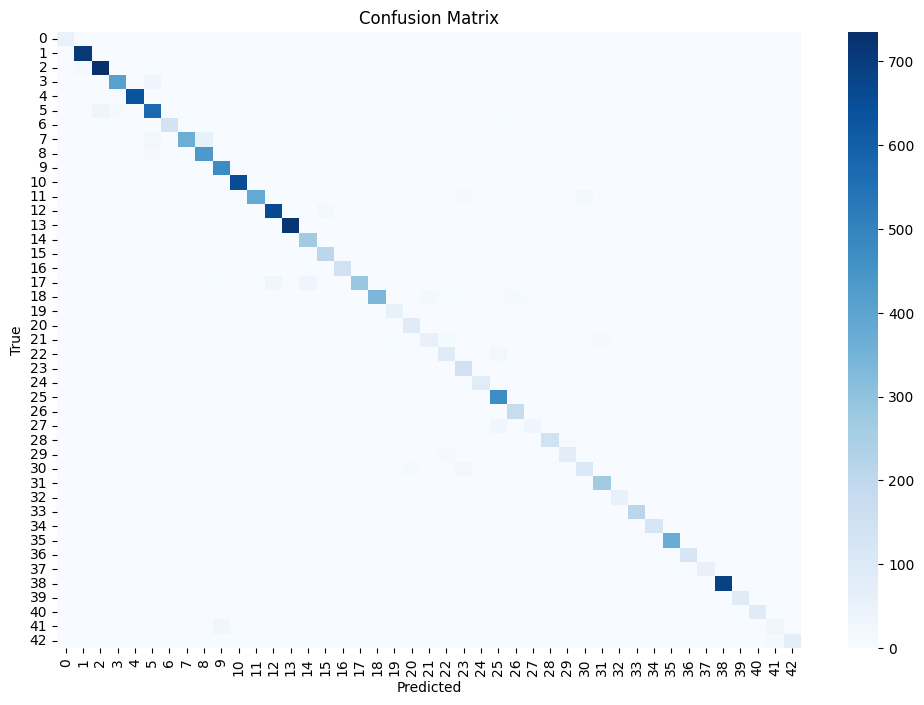


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94        60
           1       0.98      0.98      0.98       720
           2       0.94      0.98      0.96       750
           3       0.97      0.91      0.94       450
           4       0.98      0.97      0.98       660
           5       0.89      0.91      0.90       630
           6       0.97      0.92      0.95       150
           7       0.99      0.81      0.89       450
           8       0.86      0.97      0.91       450
           9       0.91      0.99      0.95       480
          10       0.99      1.00      0.99       660
          11       0.98      0.91      0.95       420
          12       0.96      0.96      0.96       690
          13       0.99      0.99      0.99       720
          14       0.89      1.00      0.94       270
          15       0.90      1.00      0.95       210
          16       1.00      1.00      1.00       150
   

In [19]:
# STEP 8: Evaluate Model
# ==============================
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

In [20]:
# STEP 9: Save Model
# ==============================
model.save("gtsrb_cnn_augmented_csv.h5")
print("Model saved as gtsrb_cnn_augmented_csv.h5")

Model saved as gtsrb_cnn_augmented_csv.h5


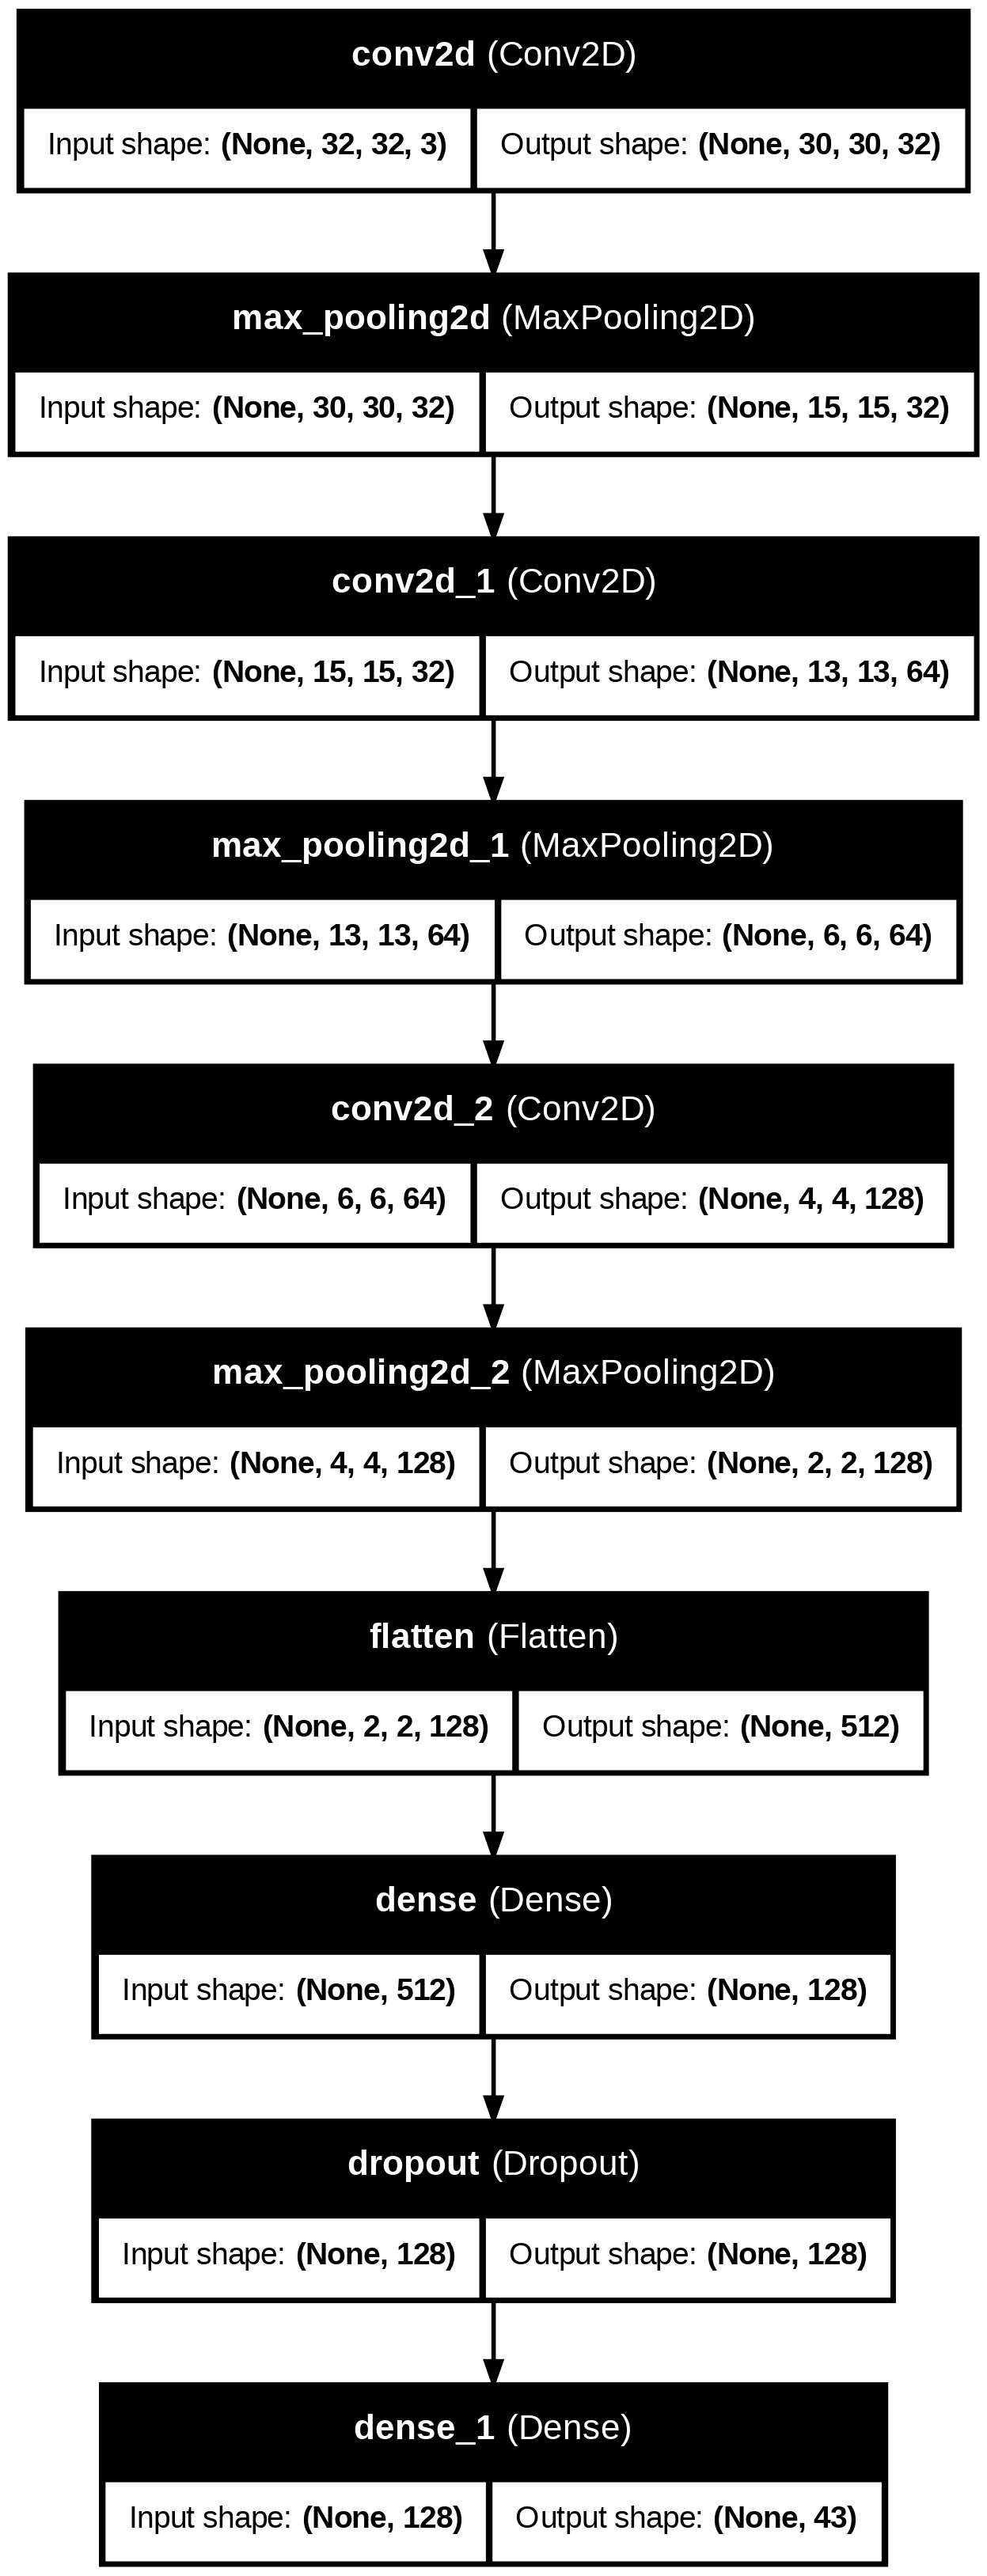

In [21]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model_structure.png", show_shapes=True, show_layer_names=True)
